In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T
from PIL import Image



In [2]:
#train_dataset = VOCSegmentation(root='data/', year='2012', image_set='train', download=True)

# writing custom dataset, inheriting from VOCSegmentation dataset
class VOCSegmentationWithPIL(VOCSegmentation):
    def __init__(self, root='data', year='2012', image_set='train',
                 download=True, image_size=(224, 224)):
        super().__init__(root=root, year=year, image_set=image_set, download=download)
        self.image_resize = T.Resize(image_size)
        self.mask_transform = T.Compose([
            T.Resize(image_size, interpolation=Image.NEAREST),
            T.PILToTensor(),  # Keeps label values intact
        ])

    def __getitem__(self, index):
        image, mask = super().__getitem__(index)
        image = self.image_resize(image)  # still PIL.Image
        mask = self.mask_transform(mask).squeeze(0).long()  # [H, W] as LongTensor
        return image, mask

In [3]:
def collate_fn_pil(batch):
    images, masks = zip(*batch)  # tuple of lists
    return list(images), torch.stack(masks)  # keep images as list of PIL


In [5]:
train_dataset = VOCSegmentationWithPIL(
    root='src/data_train',
    year='2012',
    image_set='train',
    download=True,
    image_size=(224, 224)
)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn_pil,
    pin_memory=True
)

Using downloaded and verified file: src/data_train/VOCtrainval_11-May-2012.tar
Extracting src/data_train/VOCtrainval_11-May-2012.tar to src/data_train


In [6]:
len(train_dataset)

1464

In [7]:
val_dataset = VOCSegmentationWithPIL(
    root='src/data_val',
    year='2012',
    image_set='val',
    download=True,
    image_size=(224, 224)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn_pil,
    pin_memory=True
)

Using downloaded and verified file: src/data_val/VOCtrainval_11-May-2012.tar
Extracting src/data_val/VOCtrainval_11-May-2012.tar to src/data_val


In [8]:
len(val_dataset)

1449

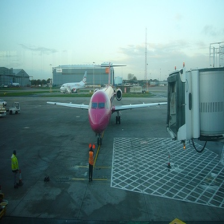

In [9]:
imgs = train_dataset[0]
imgs[0]

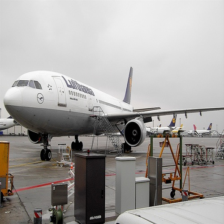

In [10]:
imgs = val_dataset[0]
imgs[0]

In [11]:
for imgs, masks in train_loader:
    print(len(imgs), len(masks)) # now images in batch are PIL and masks in batch are Tensor
    print(imgs[0], masks[0])
    break

8 8
<PIL.Image.Image image mode=RGB size=224x224 at 0x79C9E0EDCF50> tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [12]:
for imgs, masks in val_loader:
    print(len(imgs), len(masks)) # now images in batch are PIL and masks in batch are Tensor
    print(imgs[0], masks[0])
    break

8 8
<PIL.Image.Image image mode=RGB size=224x224 at 0x79C9E0EDF010> tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [ ]:
# from torchvision import transforms
# def resize_image(img):
#     """Resize the input image using torchvision transforms
#     """
#     # here my image is already in PIL format so NO need to do the below code.
#     #to_pil_image = transforms.ToPILImage()
#     resize_transform = transforms.Resize(size=(224, 224))

#     # return resize_transform(to_pil_image(img))
#     return resize_transform(img)

In [13]:
import torch
from transformers import AutoImageProcessor, Dinov2Model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large")
dino_model = Dinov2Model.from_pretrained("facebook/dinov2-large").to(device)

for images, masks in train_loader:
    # images: list of 8 PIL images
    # masks: [B, H, W] tensor

    inputs = image_processor(images, return_tensors='pt').to(device)
    dino_feats = dino_model(inputs.pixel_values).last_hidden_state  # [B, 257, 1024]

    # skip [CLS] token
    dino_feats = dino_feats[:, 1:, :]  # [B, 256, 1024]
    dino_feats = dino_feats.reshape(-1, 16, 16, 1024).permute(0, 3, 1, 2)  # [B, 1024, 16, 16]

    # ... pass dino_feats into your segmentation head ...
    break  # just test 1 batch

# torch.unique(masks[3])
dino_feats.shape, masks.shape

(torch.Size([8, 1024, 16, 16]), torch.Size([8, 224, 224]))

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class UNetDecoder(nn.Module):
    def __init__(self, in_channels=1024, num_classes=21):
        super().__init__()

        # Upsample from 16x16 → 32x32 → 64x64 → 128x128 → 224x224 (final)
        self.up1 = self._upsample_block(in_channels, 512)
        self.up2 = self._upsample_block(512, 256)
        self.up3 = self._upsample_block(256, 128)
        self.up4 = self._upsample_block(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def _upsample_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up1(x)  # 16 → 32
        x = self.up2(x)  # 32 → 64
        x = self.up3(x)  # 64 → 128
        x = self.up4(x)  # 128 → ~256
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)  # match input size
        x = self.final_conv(x)
        return x  # [B, num_classes, 224, 224]


In [15]:
class DinoSegModel(nn.Module):
    def __init__(self, freeze_dino=True, num_classes=21):
        super().__init__()
        self.dino = Dinov2Model.from_pretrained("facebook/dinov2-large")
        self.decoder = UNetDecoder(in_channels=1024, num_classes=num_classes)

        if freeze_dino:
            for param in self.dino.parameters():
                param.requires_grad = False

    def forward(self, pixel_values):  # [B, 3, 224, 224]
        feats = self.dino(pixel_values).last_hidden_state  # [B, 257, 1024]
        feats = feats[:, 1:, :]  # remove CLS token
        feats = feats.reshape(-1, 16, 16, 1024).permute(0, 3, 1, 2)  # [B, 1024, 16, 16]
        seg_logits = self.decoder(feats)  # [B, num_classes, 224, 224]
        return seg_logits


Epoch 1/100: 100%|██████████| 183/183 [00:43<00:00,  4.19it/s, loss=1.73]


Epoch 1 | Train Loss: 1.9358 | Val Loss: 0.2738


Epoch 2/100: 100%|██████████| 183/183 [00:45<00:00,  4.03it/s, loss=1.05] 


Epoch 2 | Train Loss: 1.2961 | Val Loss: 0.2738


Epoch 3/100: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.673]


Epoch 3 | Train Loss: 0.9192 | Val Loss: 0.2738


Epoch 4/100: 100%|██████████| 183/183 [00:45<00:00,  4.04it/s, loss=0.496]


Epoch 4 | Train Loss: 0.6324 | Val Loss: 0.2738


Epoch 5/100: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.375]


Epoch 5 | Train Loss: 0.4618 | Val Loss: 0.2738


Epoch 6/100: 100%|██████████| 183/183 [00:45<00:00,  4.02it/s, loss=0.43] 


Epoch 6 | Train Loss: 0.3539 | Val Loss: 0.2738


Epoch 7/100: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.258]


Epoch 7 | Train Loss: 0.2840 | Val Loss: 0.2738


Epoch 8/100: 100%|██████████| 183/183 [00:45<00:00,  4.05it/s, loss=0.193]


Epoch 8 | Train Loss: 0.2448 | Val Loss: 0.2738


Epoch 9/100: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.243]


Epoch 9 | Train Loss: 0.2107 | Val Loss: 0.2738


Validation Epoch 10:   0%|          | 0/182 [00:00<?, ?it/s]

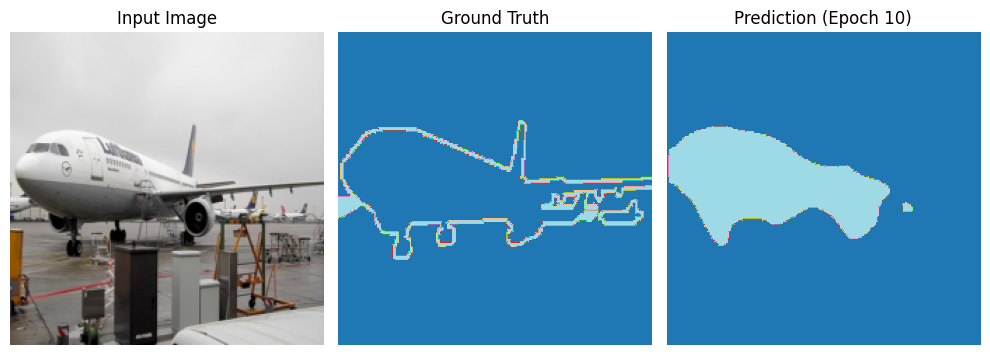

Validation Epoch 10: 100%|██████████| 182/182 [00:40<00:00,  4.53it/s]


Epoch 10 | Train Loss: 0.1802 | Val Loss: 0.2148


Epoch 11/100: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.161]


Epoch 11 | Train Loss: 0.1661 | Val Loss: 0.2148


Epoch 12/100: 100%|██████████| 183/183 [00:45<00:00,  4.03it/s, loss=0.111] 


Epoch 12 | Train Loss: 0.1558 | Val Loss: 0.2148


Epoch 13/100: 100%|██████████| 183/183 [00:50<00:00,  3.62it/s, loss=0.12]  


Epoch 13 | Train Loss: 0.1371 | Val Loss: 0.2148


Epoch 14/100: 100%|██████████| 183/183 [00:45<00:00,  4.02it/s, loss=0.179] 


Epoch 14 | Train Loss: 0.1289 | Val Loss: 0.2148


Epoch 15/100: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.114] 


Epoch 15 | Train Loss: 0.1140 | Val Loss: 0.2148


Epoch 16/100: 100%|██████████| 183/183 [00:45<00:00,  4.04it/s, loss=0.0709]


Epoch 16 | Train Loss: 0.1162 | Val Loss: 0.2148


Epoch 17/100: 100%|██████████| 183/183 [00:50<00:00,  3.61it/s, loss=0.0888]


Epoch 17 | Train Loss: 0.0999 | Val Loss: 0.2148


Epoch 18/100: 100%|██████████| 183/183 [00:45<00:00,  4.03it/s, loss=0.0607]


Epoch 18 | Train Loss: 0.0906 | Val Loss: 0.2148


Epoch 19/100: 100%|██████████| 183/183 [00:51<00:00,  3.57it/s, loss=0.114] 


Epoch 19 | Train Loss: 0.0864 | Val Loss: 0.2148


Validation Epoch 20:   0%|          | 0/182 [00:00<?, ?it/s]

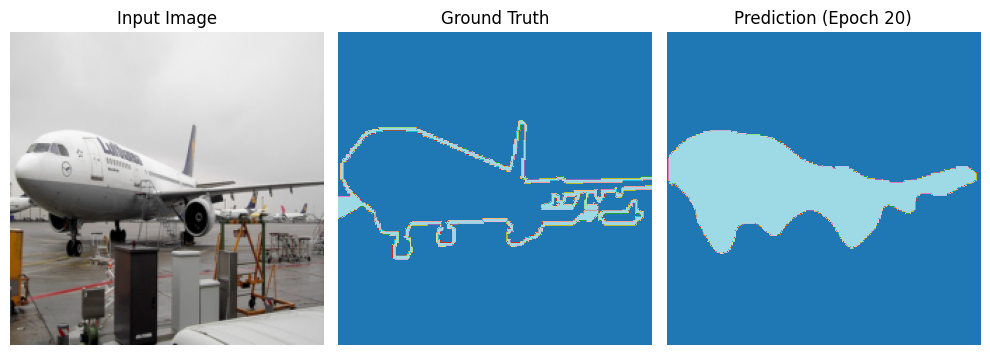

Validation Epoch 20: 100%|██████████| 182/182 [00:36<00:00,  4.95it/s]


Epoch 20 | Train Loss: 0.0815 | Val Loss: 0.1856


Epoch 21/100: 100%|██████████| 183/183 [00:51<00:00,  3.57it/s, loss=0.0579]


Epoch 21 | Train Loss: 0.0785 | Val Loss: 0.1856


Epoch 22/100: 100%|██████████| 183/183 [00:45<00:00,  4.05it/s, loss=0.071] 


Epoch 22 | Train Loss: 0.0727 | Val Loss: 0.1856


Epoch 23/100: 100%|██████████| 183/183 [00:31<00:00,  5.76it/s, loss=0.0688]


Epoch 23 | Train Loss: 0.0724 | Val Loss: 0.1856


Epoch 24/100: 100%|██████████| 183/183 [00:25<00:00,  7.10it/s, loss=0.091] 


Epoch 24 | Train Loss: 0.0739 | Val Loss: 0.1856


Epoch 25/100: 100%|██████████| 183/183 [00:25<00:00,  7.12it/s, loss=0.0615]


Epoch 25 | Train Loss: 0.0669 | Val Loss: 0.1856


Epoch 26/100: 100%|██████████| 183/183 [00:25<00:00,  7.14it/s, loss=0.0563]


Epoch 26 | Train Loss: 0.0630 | Val Loss: 0.1856


Epoch 27/100: 100%|██████████| 183/183 [00:25<00:00,  7.14it/s, loss=0.0555]


Epoch 27 | Train Loss: 0.0631 | Val Loss: 0.1856


Epoch 28/100: 100%|██████████| 183/183 [00:25<00:00,  7.14it/s, loss=0.0589]


Epoch 28 | Train Loss: 0.0586 | Val Loss: 0.1856


Epoch 29/100: 100%|██████████| 183/183 [00:25<00:00,  7.14it/s, loss=0.0389]


Epoch 29 | Train Loss: 0.0559 | Val Loss: 0.1856


Validation Epoch 30:   0%|          | 0/182 [00:00<?, ?it/s]

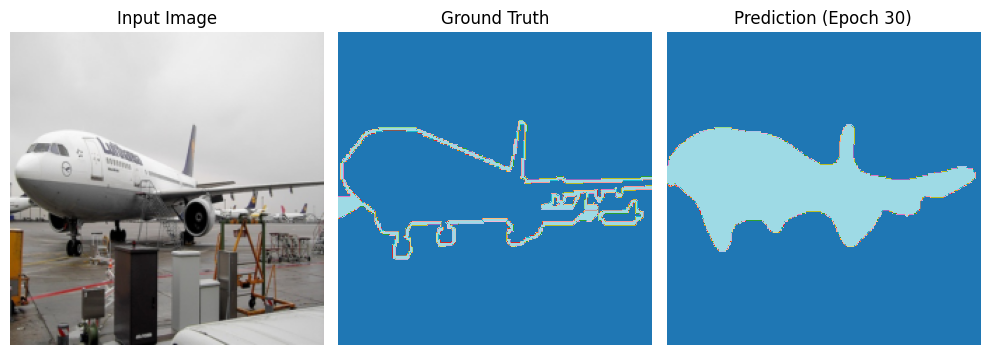

Validation Epoch 30: 100%|██████████| 182/182 [00:20<00:00,  8.79it/s]


Epoch 30 | Train Loss: 0.0532 | Val Loss: 0.1806


Epoch 31/100: 100%|██████████| 183/183 [00:25<00:00,  7.13it/s, loss=0.043] 


Epoch 31 | Train Loss: 0.0508 | Val Loss: 0.1806


Epoch 32/100: 100%|██████████| 183/183 [00:25<00:00,  7.09it/s, loss=0.039] 


Epoch 32 | Train Loss: 0.0489 | Val Loss: 0.1806


Epoch 33/100: 100%|██████████| 183/183 [00:25<00:00,  7.13it/s, loss=0.0246]


Epoch 33 | Train Loss: 0.0470 | Val Loss: 0.1806


Epoch 34/100: 100%|██████████| 183/183 [00:25<00:00,  7.13it/s, loss=0.0506]


Epoch 34 | Train Loss: 0.0454 | Val Loss: 0.1806


Epoch 35/100: 100%|██████████| 183/183 [00:25<00:00,  7.17it/s, loss=0.0678]


Epoch 35 | Train Loss: 0.0470 | Val Loss: 0.1806


Epoch 36/100: 100%|██████████| 183/183 [00:45<00:00,  4.03it/s, loss=0.071] 


Epoch 36 | Train Loss: 0.0486 | Val Loss: 0.1806


Epoch 37/100: 100%|██████████| 183/183 [00:50<00:00,  3.65it/s, loss=0.0673]


Epoch 37 | Train Loss: 0.0461 | Val Loss: 0.1806


Epoch 38/100: 100%|██████████| 183/183 [00:46<00:00,  3.94it/s, loss=0.0459]


Epoch 38 | Train Loss: 0.0563 | Val Loss: 0.1806


Epoch 39/100: 100%|██████████| 183/183 [00:50<00:00,  3.65it/s, loss=0.0331]


Epoch 39 | Train Loss: 0.0441 | Val Loss: 0.1806


Validation Epoch 40:   0%|          | 0/182 [00:00<?, ?it/s]

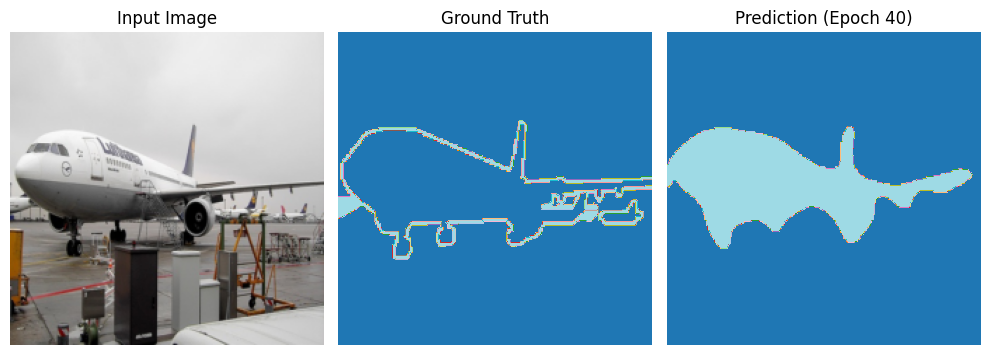

Validation Epoch 40: 100%|██████████| 182/182 [00:40<00:00,  4.53it/s]


Epoch 40 | Train Loss: 0.0409 | Val Loss: 0.1876


Epoch 41/100: 100%|██████████| 183/183 [00:46<00:00,  3.94it/s, loss=0.0388]


Epoch 41 | Train Loss: 0.0473 | Val Loss: 0.1876


Epoch 42/100: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.0337]


Epoch 42 | Train Loss: 0.0408 | Val Loss: 0.1876


Epoch 43/100: 100%|██████████| 183/183 [00:48<00:00,  3.74it/s, loss=0.0567]


Epoch 43 | Train Loss: 0.0375 | Val Loss: 0.1876


Epoch 44/100: 100%|██████████| 183/183 [00:47<00:00,  3.82it/s, loss=0.0285]


Epoch 44 | Train Loss: 0.0348 | Val Loss: 0.1876


Epoch 45/100: 100%|██████████| 183/183 [00:50<00:00,  3.62it/s, loss=0.042] 


Epoch 45 | Train Loss: 0.0347 | Val Loss: 0.1876


Epoch 46/100: 100%|██████████| 183/183 [00:45<00:00,  3.99it/s, loss=0.0297]


Epoch 46 | Train Loss: 0.0330 | Val Loss: 0.1876


Epoch 47/100: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.0129]


Epoch 47 | Train Loss: 0.0315 | Val Loss: 0.1876


Epoch 48/100: 100%|██████████| 183/183 [00:45<00:00,  4.05it/s, loss=0.0241]


Epoch 48 | Train Loss: 0.0307 | Val Loss: 0.1876


Epoch 49/100: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.0234]


Epoch 49 | Train Loss: 0.0324 | Val Loss: 0.1876


Validation Epoch 50:   0%|          | 0/182 [00:00<?, ?it/s]

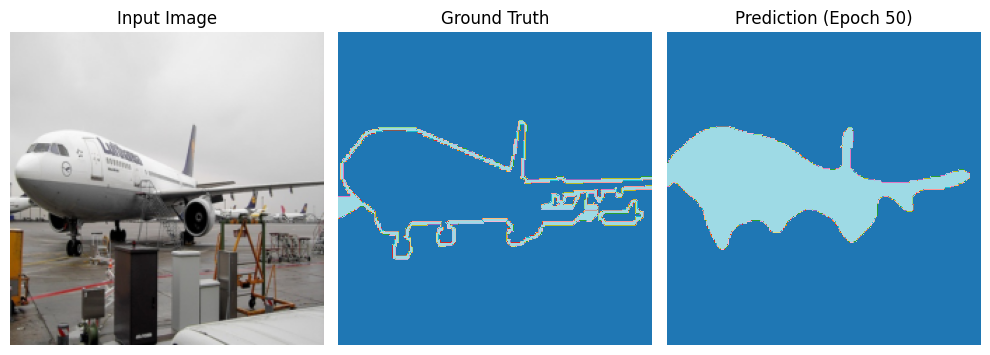

Validation Epoch 50: 100%|██████████| 182/182 [00:40<00:00,  4.53it/s]


Epoch 50 | Train Loss: 0.0314 | Val Loss: 0.1957


Epoch 51/100: 100%|██████████| 183/183 [00:47<00:00,  3.84it/s, loss=0.0367]


Epoch 51 | Train Loss: 0.0320 | Val Loss: 0.1957


Epoch 52/100: 100%|██████████| 183/183 [00:48<00:00,  3.76it/s, loss=0.0321]


Epoch 52 | Train Loss: 0.0346 | Val Loss: 0.1957


Epoch 53/100: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.0249]


Epoch 53 | Train Loss: 0.0299 | Val Loss: 0.1957


Epoch 54/100: 100%|██████████| 183/183 [00:45<00:00,  4.03it/s, loss=0.0184]


Epoch 54 | Train Loss: 0.0270 | Val Loss: 0.1957


Epoch 55/100: 100%|██████████| 183/183 [00:50<00:00,  3.62it/s, loss=0.0234]


Epoch 55 | Train Loss: 0.0259 | Val Loss: 0.1957


Epoch 56/100: 100%|██████████| 183/183 [00:45<00:00,  4.03it/s, loss=0.0171]


Epoch 56 | Train Loss: 0.0259 | Val Loss: 0.1957


Epoch 57/100: 100%|██████████| 183/183 [00:50<00:00,  3.60it/s, loss=0.0353] 


Epoch 57 | Train Loss: 0.0266 | Val Loss: 0.1957


Epoch 58/100: 100%|██████████| 183/183 [00:45<00:00,  4.00it/s, loss=0.0155]


Epoch 58 | Train Loss: 0.0276 | Val Loss: 0.1957


Epoch 59/100: 100%|██████████| 183/183 [00:51<00:00,  3.56it/s, loss=0.0274]


Epoch 59 | Train Loss: 0.0262 | Val Loss: 0.1957


Validation Epoch 60:   0%|          | 0/182 [00:00<?, ?it/s]

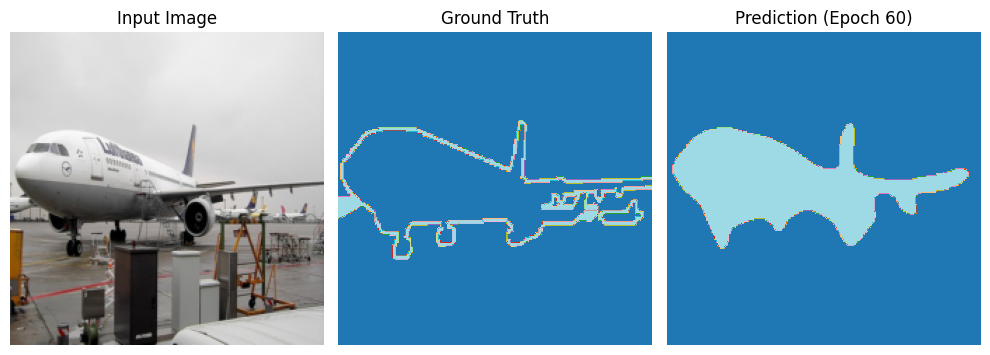

Validation Epoch 60: 100%|██████████| 182/182 [00:40<00:00,  4.53it/s]


Epoch 60 | Train Loss: 0.0273 | Val Loss: 0.2116


Epoch 61/100: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.0497]


Epoch 61 | Train Loss: 0.0372 | Val Loss: 0.2116


Epoch 62/100: 100%|██████████| 183/183 [00:45<00:00,  4.02it/s, loss=0.0218]


Epoch 62 | Train Loss: 0.0437 | Val Loss: 0.2116


Epoch 63/100: 100%|██████████| 183/183 [00:50<00:00,  3.61it/s, loss=0.0335]


Epoch 63 | Train Loss: 0.0351 | Val Loss: 0.2116


Epoch 64/100: 100%|██████████| 183/183 [00:45<00:00,  4.02it/s, loss=0.0345] 


Epoch 64 | Train Loss: 0.0246 | Val Loss: 0.2116


Epoch 65/100: 100%|██████████| 183/183 [00:50<00:00,  3.64it/s, loss=0.0208] 


Epoch 65 | Train Loss: 0.0220 | Val Loss: 0.2116


Epoch 66/100: 100%|██████████| 183/183 [00:45<00:00,  4.04it/s, loss=0.0144]


Epoch 66 | Train Loss: 0.0200 | Val Loss: 0.2116


Epoch 67/100: 100%|██████████| 183/183 [00:50<00:00,  3.62it/s, loss=0.00798]


Epoch 67 | Train Loss: 0.0207 | Val Loss: 0.2116


Epoch 68/100: 100%|██████████| 183/183 [00:45<00:00,  3.98it/s, loss=0.033]  


Epoch 68 | Train Loss: 0.0198 | Val Loss: 0.2116


Epoch 69/100: 100%|██████████| 183/183 [00:50<00:00,  3.64it/s, loss=0.0276] 


Epoch 69 | Train Loss: 0.0196 | Val Loss: 0.2116


Validation Epoch 70:   0%|          | 0/182 [00:00<?, ?it/s]

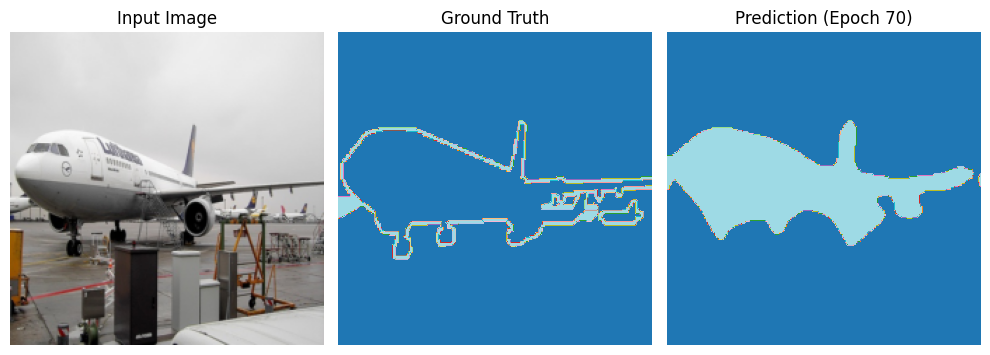

Validation Epoch 70: 100%|██████████| 182/182 [00:39<00:00,  4.59it/s]


Epoch 70 | Train Loss: 0.0222 | Val Loss: 0.2259


Epoch 71/100: 100%|██████████| 183/183 [00:50<00:00,  3.62it/s, loss=0.0259] 


Epoch 71 | Train Loss: 0.0220 | Val Loss: 0.2259


Epoch 72/100: 100%|██████████| 183/183 [00:45<00:00,  4.01it/s, loss=0.0258] 


Epoch 72 | Train Loss: 0.0218 | Val Loss: 0.2259


Epoch 73/100: 100%|██████████| 183/183 [00:50<00:00,  3.62it/s, loss=0.0262] 


Epoch 73 | Train Loss: 0.0198 | Val Loss: 0.2259


Epoch 74/100: 100%|██████████| 183/183 [00:45<00:00,  3.99it/s, loss=0.0302] 


Epoch 74 | Train Loss: 0.0196 | Val Loss: 0.2259


Epoch 75/100: 100%|██████████| 183/183 [00:51<00:00,  3.58it/s, loss=0.0142] 


Epoch 75 | Train Loss: 0.0192 | Val Loss: 0.2259


Epoch 76/100: 100%|██████████| 183/183 [00:45<00:00,  4.03it/s, loss=0.0125] 


Epoch 76 | Train Loss: 0.0201 | Val Loss: 0.2259


Epoch 77/100: 100%|██████████| 183/183 [00:50<00:00,  3.62it/s, loss=0.014]  


Epoch 77 | Train Loss: 0.0207 | Val Loss: 0.2259


Epoch 78/100: 100%|██████████| 183/183 [00:45<00:00,  4.03it/s, loss=0.0373] 


Epoch 78 | Train Loss: 0.0205 | Val Loss: 0.2259


Epoch 79/100: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.0127] 


Epoch 79 | Train Loss: 0.0204 | Val Loss: 0.2259


Validation Epoch 80:   0%|          | 0/182 [00:00<?, ?it/s]

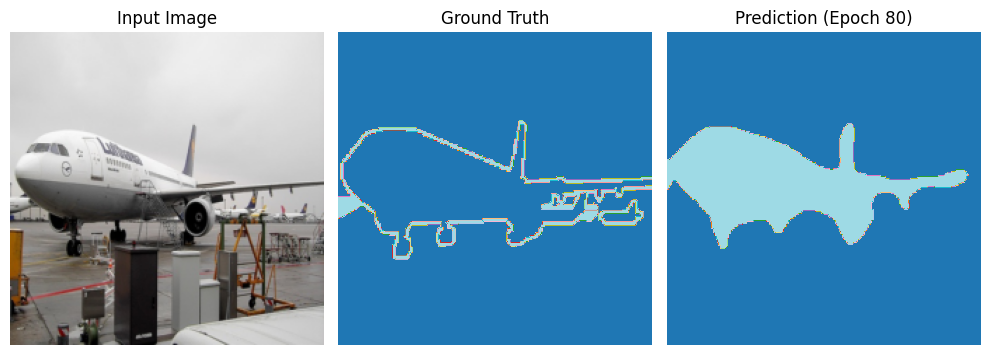

Validation Epoch 80: 100%|██████████| 182/182 [00:35<00:00,  5.12it/s]


Epoch 80 | Train Loss: 0.0195 | Val Loss: 0.2293


Epoch 81/100: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.0188] 


Epoch 81 | Train Loss: 0.0190 | Val Loss: 0.2293


Epoch 82/100: 100%|██████████| 183/183 [00:45<00:00,  4.03it/s, loss=0.0367] 


Epoch 82 | Train Loss: 0.0179 | Val Loss: 0.2293


Epoch 83/100: 100%|██████████| 183/183 [00:50<00:00,  3.61it/s, loss=0.0248] 


Epoch 83 | Train Loss: 0.0169 | Val Loss: 0.2293


Epoch 84/100: 100%|██████████| 183/183 [00:45<00:00,  4.03it/s, loss=0.0147] 


Epoch 84 | Train Loss: 0.0168 | Val Loss: 0.2293


Epoch 85/100: 100%|██████████| 183/183 [00:50<00:00,  3.60it/s, loss=0.034]  


Epoch 85 | Train Loss: 0.0175 | Val Loss: 0.2293


Epoch 86/100: 100%|██████████| 183/183 [00:45<00:00,  4.02it/s, loss=0.0277] 


Epoch 86 | Train Loss: 0.0168 | Val Loss: 0.2293


Epoch 87/100: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.0186] 


Epoch 87 | Train Loss: 0.0169 | Val Loss: 0.2293


Epoch 88/100: 100%|██████████| 183/183 [00:49<00:00,  3.66it/s, loss=0.0169] 


Epoch 88 | Train Loss: 0.0169 | Val Loss: 0.2293


Epoch 89/100: 100%|██████████| 183/183 [00:46<00:00,  3.95it/s, loss=0.0234] 


Epoch 89 | Train Loss: 0.0172 | Val Loss: 0.2293


Validation Epoch 90:   0%|          | 0/182 [00:00<?, ?it/s]

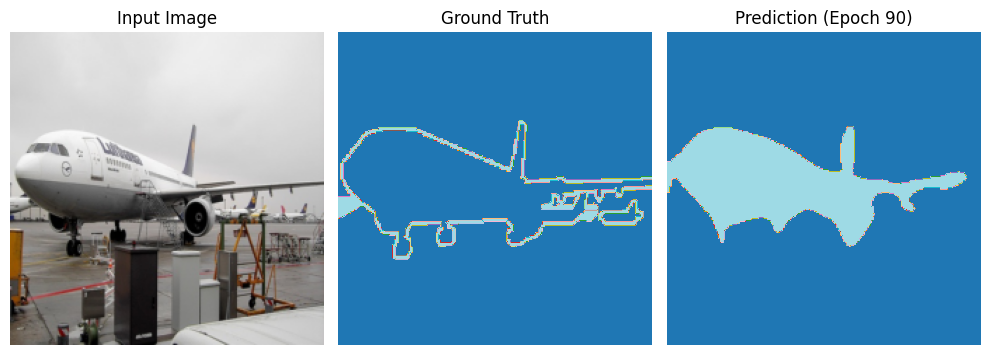

Validation Epoch 90: 100%|██████████| 182/182 [00:35<00:00,  5.14it/s]


Epoch 90 | Train Loss: 0.0175 | Val Loss: 0.2438


Epoch 91/100: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.0125] 


Epoch 91 | Train Loss: 0.0165 | Val Loss: 0.2438


Epoch 92/100: 100%|██████████| 183/183 [00:45<00:00,  3.98it/s, loss=0.0185] 


Epoch 92 | Train Loss: 0.0188 | Val Loss: 0.2438


Epoch 93/100: 100%|██████████| 183/183 [00:50<00:00,  3.60it/s, loss=0.0348] 


Epoch 93 | Train Loss: 0.0271 | Val Loss: 0.2438


Epoch 94/100: 100%|██████████| 183/183 [00:45<00:00,  4.05it/s, loss=0.0202] 


Epoch 94 | Train Loss: 0.0282 | Val Loss: 0.2438


Epoch 95/100: 100%|██████████| 183/183 [00:50<00:00,  3.62it/s, loss=0.0163] 


Epoch 95 | Train Loss: 0.0174 | Val Loss: 0.2438


Epoch 96/100: 100%|██████████| 183/183 [00:48<00:00,  3.75it/s, loss=0.00556]


Epoch 96 | Train Loss: 0.0144 | Val Loss: 0.2438


Epoch 97/100: 100%|██████████| 183/183 [00:47<00:00,  3.88it/s, loss=0.0103] 


Epoch 97 | Train Loss: 0.0134 | Val Loss: 0.2438


Epoch 98/100: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.0242] 


Epoch 98 | Train Loss: 0.0135 | Val Loss: 0.2438


Epoch 99/100: 100%|██████████| 183/183 [00:45<00:00,  4.05it/s, loss=0.00913]


Epoch 99 | Train Loss: 0.0131 | Val Loss: 0.2438


Validation Epoch 100:   0%|          | 0/182 [00:00<?, ?it/s]

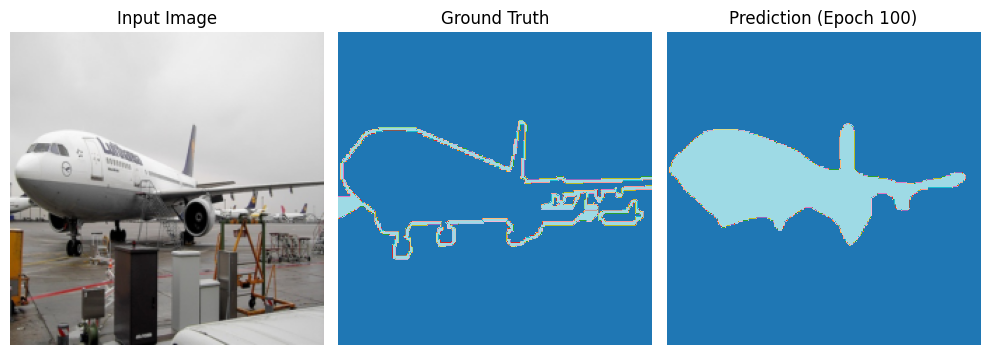

Validation Epoch 100: 100%|██████████| 182/182 [00:35<00:00,  5.16it/s]

Epoch 100 | Train Loss: 0.0129 | Val Loss: 0.2540


In [18]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm  # progress bar

# Model Setup
image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large")
model = DinoSegModel(freeze_dino=True).to(device)  # freeze_dino=False for fine-tuning

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

num_epochs = 100
train_losses = []
val_losses = []

model.train()

def evaluate(model, val_loader, criterion, image_processor, device, epoch):
    model.eval()
    val_loss = 0.0
    
    val_loop = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}")

    with torch.no_grad():
        for step, (images, masks) in enumerate(val_loop):
            inputs = image_processor(images, return_tensors='pt').to(device)
            masks = masks.to(device)

            outputs = model(inputs.pixel_values)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            if step == 0:
                # Show predictions on first batch
                preds = outputs.argmax(dim=1)
                plt.figure(figsize=(10, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(images[0])
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(masks[0].cpu(), cmap='tab20')
                plt.title("Ground Truth")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(preds[0].cpu(), cmap='tab20')
                plt.title(f"Prediction (Epoch {epoch+1})")
                plt.axis("off")
                plt.tight_layout()
                plt.show()

    # model.train()
    return val_loss / len(val_loader)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, masks in loop:
        inputs = image_processor(images, return_tensors='pt').to(device)
        masks = masks.to(device)

        outputs = model(inputs.pixel_values)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)
    #avg_val_loss = evaluate(model, val_loader, criterion, image_processor, device, epoch)
    # Only evaluate every 10 epochs
    if (epoch + 1) % 10 == 0:
        avg_val_loss = evaluate(model, val_loader, criterion, image_processor, device, epoch)
        val_losses.append(avg_val_loss)

    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


In [19]:
len(train_losses), len(val_losses)

(100, 10)

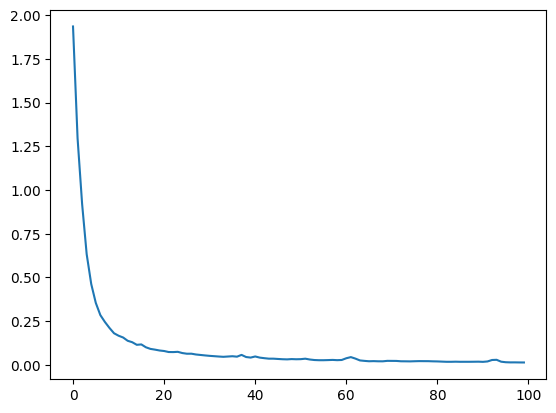

In [24]:
plt.plot(range(num_epochs), train_losses, label='Train Loss')

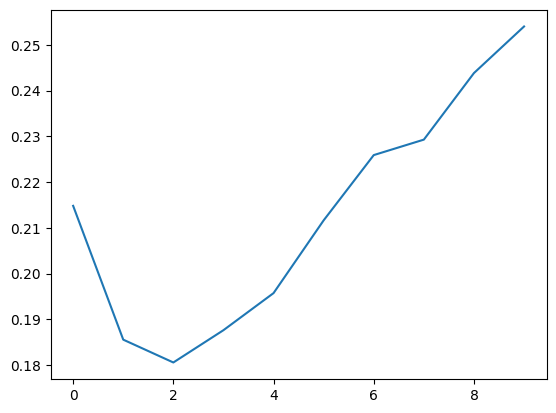

In [26]:
plt.plot(range(10), val_losses, label='Train Loss')

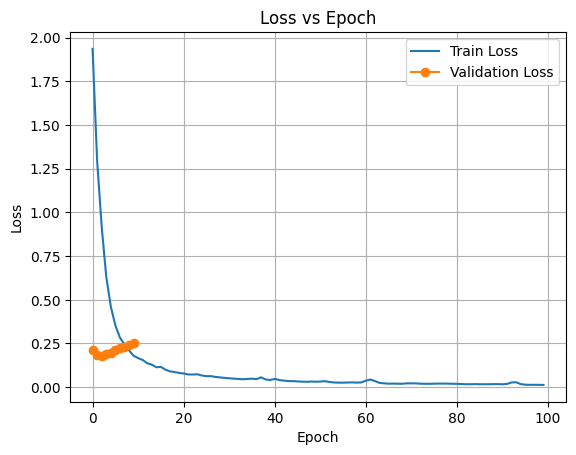

In [23]:
import matplotlib.pyplot as plt

plt.figure()

# Plot train loss (has value every epoch)
plt.plot(range(num_epochs), train_losses, label='Train Loss')

# Prepare filtered val loss and x-ticks
val_epochs = [i for i, v in enumerate(val_losses) if v is not None]
val_values = [v for v in val_losses if v is not None]

plt.plot(val_epochs, val_values, label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
# plt.savefig('loss_plot.png')
# plt.close()


### With checkpoints

In [27]:
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassJaccardIndex
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# ------------------ Setup ------------------
num_classes = 21
ignore_index = 255
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = DinoSegModel(freeze_dino=True).to(device)
image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large")

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Metric
miou_metric = MulticlassJaccardIndex(num_classes=num_classes, ignore_index=ignore_index).to(device)

# Training config
num_epochs = 20
train_losses, val_losses, val_ious = [], [], []

# Paths
best_model_path = "best_model.pth"
checkpoint_path = "last_checkpoint.pth"
best_val_loss = float('inf')
start_epoch = 0

# ------------------ Load from Checkpoint (if exists) ------------------
# if os.path.exists(checkpoint_path):
#     checkpoint = torch.load(checkpoint_path)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
#     start_epoch = checkpoint['epoch'] + 1
#     best_val_loss = checkpoint['best_val_loss']
#     print(f"Resumed training from checkpoint at epoch {start_epoch}")

# ------------------ Validation ------------------
def evaluate(model, loader, criterion, image_processor, device, epoch):
    model.eval()
    val_loss = 0.0
    miou_metric.reset()
    save_dir = os.path.join("val_preds", f"epoch_{epoch+1}")
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        val_loop = tqdm(loader, desc=f"Validation Epoch {epoch+1}")
        for step, (images, masks) in enumerate(val_loop):
            inputs = image_processor(images, return_tensors='pt').to(device)
            masks = masks.to(device)
            outputs = model(inputs.pixel_values)

            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_loop.set_postfix(val_loss=loss.item())

            preds = outputs.argmax(dim=1)
            miou_metric.update(preds, masks)

            # Save every sample in the batch
            for i in range(len(images)):
                image_np = images[i]
                mask_np = masks[i].cpu().numpy()
                pred_np = preds[i].cpu().numpy()

                #plt.imsave(os.path.join(save_dir, f"image_{step}_{i}.jpg"), image_np)
                plt.imsave(os.path.join(save_dir, f"gt_{step}_{i}.png"), mask_np, cmap='nipy_spectral')
                plt.imsave(os.path.join(save_dir, f"pred_{step}_{i}.png"), pred_np, cmap='nipy_spectral')

    return val_loss / len(loader), miou_metric.compute().item()

# ------------------ Training Loop ------------------
for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, masks in loop:
        inputs = image_processor(images, return_tensors='pt').to(device)
        masks = masks.to(device)

        outputs = model(inputs.pixel_values)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate only every 10 epochs
    if (epoch + 1) % 20 == 0:
        avg_val_loss, val_miou = evaluate(model, val_loader, criterion, image_processor, device, epoch)
        scheduler.step(avg_val_loss)
        val_losses.append(avg_val_loss)
        val_ious.append(val_miou)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val mIoU: {val_miou:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model at epoch {epoch+1} with val loss {avg_val_loss:.4f}")
    else:
        val_losses.append(None)
        val_ious.append(None)

    # Save checkpoint every epoch
    # checkpoint = {
    #     'epoch': epoch,
    #     'model_state_dict': model.state_dict(),
    #     'optimizer_state_dict': optimizer.state_dict(),
    #     'scheduler_state_dict': scheduler.state_dict(),
    #     'best_val_loss': best_val_loss
    # }
    # torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")


/home/iiitb/anaconda3/envs/deeplearning/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 1/20: 100%|██████████| 183/183 [00:50<00:00,  3.65it/s, loss=1.57]


Checkpoint saved at epoch 1


Epoch 2/20: 100%|██████████| 183/183 [00:45<00:00,  4.03it/s, loss=0.842]


Checkpoint saved at epoch 2


Epoch 3/20: 100%|██████████| 183/183 [00:50<00:00,  3.59it/s, loss=0.708]


Checkpoint saved at epoch 3


Epoch 4/20: 100%|██████████| 183/183 [00:45<00:00,  4.04it/s, loss=0.716]


Checkpoint saved at epoch 4


Epoch 5/20: 100%|██████████| 183/183 [00:51<00:00,  3.55it/s, loss=0.397]


Checkpoint saved at epoch 5


Epoch 6/20: 100%|██████████| 183/183 [00:45<00:00,  4.01it/s, loss=0.499]


Checkpoint saved at epoch 6


Epoch 7/20: 100%|██████████| 183/183 [00:50<00:00,  3.62it/s, loss=0.19] 


Checkpoint saved at epoch 7


Epoch 8/20: 100%|██████████| 183/183 [00:45<00:00,  4.03it/s, loss=0.157]


Checkpoint saved at epoch 8


Epoch 9/20: 100%|██████████| 183/183 [00:50<00:00,  3.61it/s, loss=0.198]


Checkpoint saved at epoch 9


Epoch 10/20: 100%|██████████| 183/183 [00:49<00:00,  3.72it/s, loss=0.174]


Checkpoint saved at epoch 10


Epoch 11/20: 100%|██████████| 183/183 [00:47<00:00,  3.85it/s, loss=0.158]


Checkpoint saved at epoch 11


Epoch 12/20: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.13] 


Checkpoint saved at epoch 12


Epoch 13/20: 100%|██████████| 183/183 [00:45<00:00,  4.02it/s, loss=0.157] 


Checkpoint saved at epoch 13


Epoch 14/20: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.145] 


Checkpoint saved at epoch 14


Epoch 15/20: 100%|██████████| 183/183 [00:45<00:00,  4.00it/s, loss=0.0795]


Checkpoint saved at epoch 15


Epoch 16/20: 100%|██████████| 183/183 [00:50<00:00,  3.62it/s, loss=0.0901]


Checkpoint saved at epoch 16


Epoch 17/20: 100%|██████████| 183/183 [00:45<00:00,  4.01it/s, loss=0.071] 


Checkpoint saved at epoch 17


Epoch 18/20: 100%|██████████| 183/183 [00:50<00:00,  3.63it/s, loss=0.0693]


Checkpoint saved at epoch 18


Epoch 19/20: 100%|██████████| 183/183 [00:45<00:00,  4.03it/s, loss=0.0794]


Checkpoint saved at epoch 19


Validation Epoch 20: 100%|██████████| 182/182 [00:45<00:00,  4.03it/s, val_loss=0.177] 


Epoch 20 | Train Loss: 0.0819 | Val Loss: 0.1786 | Val mIoU: 0.7670
Saved best model at epoch 20 with val loss 0.1786
Checkpoint saved at epoch 20


In [28]:
val_losses

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 0.17861620930361224]

In [29]:
val_ious

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 0.7670261859893799]

In [30]:
train_losses

[1.7310991717166588,
 1.141987234191165,
 0.8008326246438782,
 0.5673962943866605,
 0.4200480520073833,
 0.3346718552985478,
 0.27159965990996754,
 0.2337426110857823,
 0.19746475475407688,
 0.18087110611421814,
 0.16357760021432502,
 0.14966285786504954,
 0.1366395894946948,
 0.12459758620281688,
 0.11214703121960488,
 0.10238998955309066,
 0.10257282908089825,
 0.09182504305992621,
 0.08605688437819481,
 0.08192651268970119]

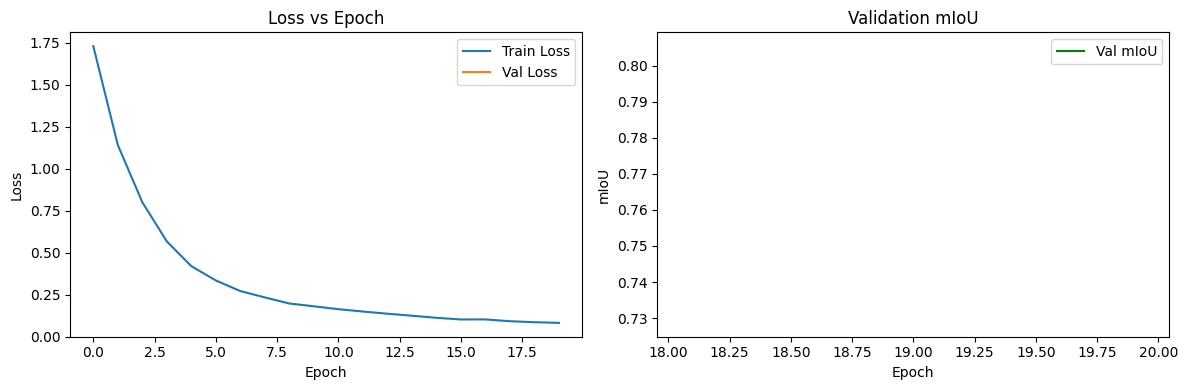

In [31]:
# Plot Loss and mIoU
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_ious, label="Val mIoU", color="green")
plt.xlabel("Epoch")
plt.ylabel("mIoU")
plt.title("Validation mIoU")
plt.legend()

plt.tight_layout()
plt.show()

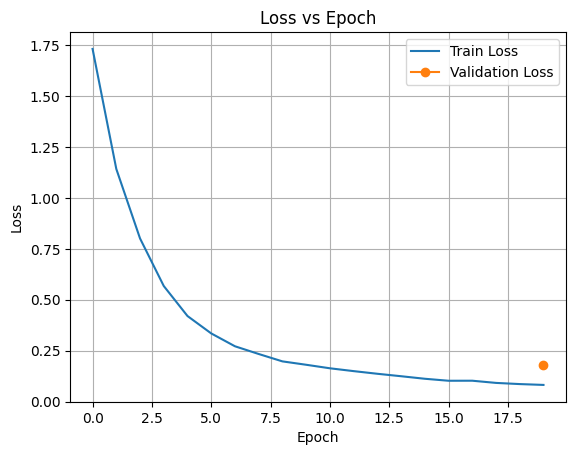

In [32]:
import matplotlib.pyplot as plt

plt.figure()

# Plot train loss (has value every epoch)
plt.plot(range(num_epochs), train_losses, label='Train Loss')

# Prepare filtered val loss and x-ticks
val_epochs = [i for i, v in enumerate(val_losses) if v is not None]
val_values = [v for v in val_losses if v is not None]

plt.plot(val_epochs, val_values, label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
# plt.savefig('loss_plot.png')
# plt.close()


In [ ]:
# for inferencing
# model.load_state_dict(torch.load("best_model.pth"))
# model.eval()

### Inference

In [33]:
import PIL

In [ ]:

#model = DinoSegModel().to(device)
#model.load_state_dict(torch.load("checkpoints/best_model.pth"))
# model.eval()

# image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large")
# img = Image.open("/home/iiitb/Desktop/anant/playground/ProjectBytes/src/pred_airplane1.png").convert("RGB")
# inputs = image_processor(img, return_tensors="pt").to(device)

# with torch.no_grad():
#     output = model(inputs.pixel_values)
#     pred = output.argmax(1).squeeze().cpu().numpy()

# plt.imshow(pred, cmap='gray')
# plt.title("Prediction")
# plt.show()


: 